# Frio Frio
https://metadata.fundacionsadosky.org.ar/competition/20/

Una “oportunidad” consiste en un proyecto de venta o instalación de equipos para un cliente. La venta se estructura alrededor de TRF (Toneladas de refrigeración) y puede estar compuesta por varios productos distintos. El "pipeline" hace referencia al flujo de oportunidades prospecto que la empresa está desarrollando. El equipo comercial asigna a distintos momentos, para cada oportunidad, un estado en la negociación. En la Ilustración se muestran los estados que las oportunidades tienen dentro del pipeline.

La variable que se está tratando de predecir es “Probabilidad de éxito” para cada oportunidad. ¿Cuál es la probabilidad de que la oportunidad se convierta en un caso Closed Won?

#### Evaluación

La calificación de la competencia se logra, en un 50%, con el resultado de las predicciones. La métrica elegida para el set de validación es la función de Logistic Loss (Log Loss). https://scikit-learn.org/stable/modules/model_evaluation.html#log-loss

En el tablero se puede ver la evaluación de la solución propuesta en una muestra del set de validación. Esta muestra puede variar durante la competencia. El total del conjunto de datos de validación se reserva hasta el final de la competencia.

El 50% restante se obtiene presentando un informe donde se deberá explicar qué tratamiento hicieron en los datos y una explicación sobre el modelo propuesto. La nota la otorga un jurado ad-hoc de especialistas en el tema evaluando el informe.

Las predicciones se deben enviar en un archivo CSV sin encabezado conteniendo solamente la identificación de la oportunidad (Opportunity_ID) del dataset de valuación y la columna de predicciones (score). A continuación, se muestran tres filas de un archivo de predicciones típico:

Opportunity_ID, score

10689, 0.33

10690, 0.9853289

10691, 0.70956707

etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Entrenamieto_ECI_2020.csv')

In [3]:
df['Account_Created_Date'] = pd.to_datetime(df['Account_Created_Date'])
df['Opportunity_Created_Date'] = pd.to_datetime(df['Opportunity_Created_Date'])
df['Last_Activity'] = pd.to_datetime(df['Last_Activity'])
df['Quote_Expiry_Date'] = pd.to_datetime(df['Quote_Expiry_Date'])
df['Last_Modified_Date'] = pd.to_datetime(df['Last_Modified_Date'])
df['Planned_Delivery_Start_Date'] = pd.to_datetime(df['Planned_Delivery_Start_Date'])
df['Planned_Delivery_End_Date'] = pd.to_datetime(df['Planned_Delivery_End_Date'])
df['Actual_Delivery_Date'] = pd.to_datetime(df['Actual_Delivery_Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 52 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID                                  16947 non-null  int64         
 1   Region                              16947 non-null  object        
 2   Territory                           16947 non-null  object        
 3   Pricing, Delivery_Terms_Quote_Appr  16947 non-null  int64         
 4   Pricing, Delivery_Terms_Approved    16947 non-null  int64         
 5   Bureaucratic_Code_0_Approval        16947 non-null  int64         
 6   Bureaucratic_Code_0_Approved        16947 non-null  int64         
 7   Submitted_for_Approval              16947 non-null  int64         
 8   Bureaucratic_Code                   16947 non-null  object        
 9   Account_Created_Date                16947 non-null  datetime64[ns]
 10  Source                

In [4]:
df['Stage'].value_counts()

Closed Won       9533
Closed Lost      7350
Proposal           35
Negotiation        18
Qualification      11
Name: Stage, dtype: int64

Comentario: Para el modelo eliminar `Stage` == 'Proposal', 'Negotiation', 'Qualification'

In [5]:
df.nunique()

ID                                    16947
Region                                    5
Territory                                76
Pricing, Delivery_Terms_Quote_Appr        2
Pricing, Delivery_Terms_Approved          2
Bureaucratic_Code_0_Approval              2
Bureaucratic_Code_0_Approved              2
Submitted_for_Approval                    1
Bureaucratic_Code                         7
Account_Created_Date                    809
Source                                   14
Billing_Country                          80
Account_Name                           1635
Opportunity_Name                       9841
Opportunity_ID                         9841
Sales_Contract_No                      5267
Account_Owner                            48
Opportunity_Owner                        53
Account_Type                              7
Opportunity_Type                         25
Quote_Type                                2
Delivery_Terms                            9
Opportunity_Created_Date        

In [6]:
df.isna().sum()

ID                                        0
Region                                    0
Territory                                 0
Pricing, Delivery_Terms_Quote_Appr        0
Pricing, Delivery_Terms_Approved          0
Bureaucratic_Code_0_Approval              0
Bureaucratic_Code_0_Approved              0
Submitted_for_Approval                    0
Bureaucratic_Code                         0
Account_Created_Date                      0
Source                                    0
Billing_Country                           0
Account_Name                              0
Opportunity_Name                          0
Opportunity_ID                            0
Sales_Contract_No                         0
Account_Owner                             0
Opportunity_Owner                         0
Account_Type                              0
Opportunity_Type                          0
Quote_Type                                0
Delivery_Terms                            0
Opportunity_Created_Date        

Comentario: Los valores Nan no parecen ser un problema en este caso.

NOTA: existen valores 'None' en distintas variables.

Voy a analizar columna por columna para entender que tiene adentro cada una y que relación tiene con `Stage`

Quiero conocer lo siguiente:
- Correlación con `Stage`
- Cantidad de valores únicos.
- Algo más??

## Función de análisis

Creo que la función `a` para obtener algunos datos para todas las features de la data

In [7]:
def a(feature):
    # Cargo los valores únicos de la feature que estoy analizando
    feature_categories = df[feature].value_counts().index
    # Imprimo el nombre de la feature
    print('Feature: ',feature)
    
#   En el caso que la cantidad de valores únicos de la feature sean menores a 100 realizo el gráfico. Caso contrario solo imprimo el número.
    if len(df[feature].value_counts())<100:
        # grafico las oportunidades ganadas (Closed_Won) y perdidas (Closed_Lost) en función de la feature elegida
        fig, ax = plt.subplots(figsize=(6,len(feature_categories)*0.7))
        ax = sns.countplot(y=feature,
                           hue="Stage",
                           data=df,
                           order=df[feature].value_counts().index)
        plt.show(ax)
    else:
        print()
        print('Los valores únicos de ',feature, 'son ',len(df[feature].value_counts()))
        print()

    # Calculo el porcentaje de oportunidades ganadas por cada valor único de la feature elegida
    feature_Closed_Won_Percentage = []

    for feature_category in feature_categories:
        feature_Closed_Won = len(df[(df[feature]==feature_category) & (df['Stage']=='Closed Won')]) / len(df[(df[feature]==feature_category)])
        feature_Closed_Won_Percentage.append(feature_Closed_Won)

    # Creo una tabla con el porcentaje de oportunidades ganadas y la cantidad de instancias por cada valor único de la feature elegida
    analisis = pd.DataFrame({'Closed_Won_Percentage': feature_Closed_Won_Percentage,
                             'Opportunities_Count': df[feature].value_counts()})

    # Imprimo el primer tercio de las categorias del feature seleccionado cuando tenga menos de 5 categorías
    if ((len(df[feature].value_counts()))<15):
        print(analisis)
    else:
        print(analisis.head(int((len(df[feature].value_counts())*0.3))))
    print()
    print()

## Region

Feature:  Region


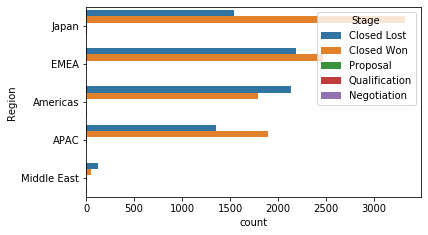

             Closed_Won_Percentage  Opportunities_Count
Japan                     0.679272                 4892
EMEA                      0.529803                 4664
Americas                  0.454499                 3945
APAC                      0.581239                 3262
Middle East               0.271739                  184




In [8]:
a('Region')

### Conclusión

Utilizar `Region` para el modelo.

## Territory

Feature:  Territory


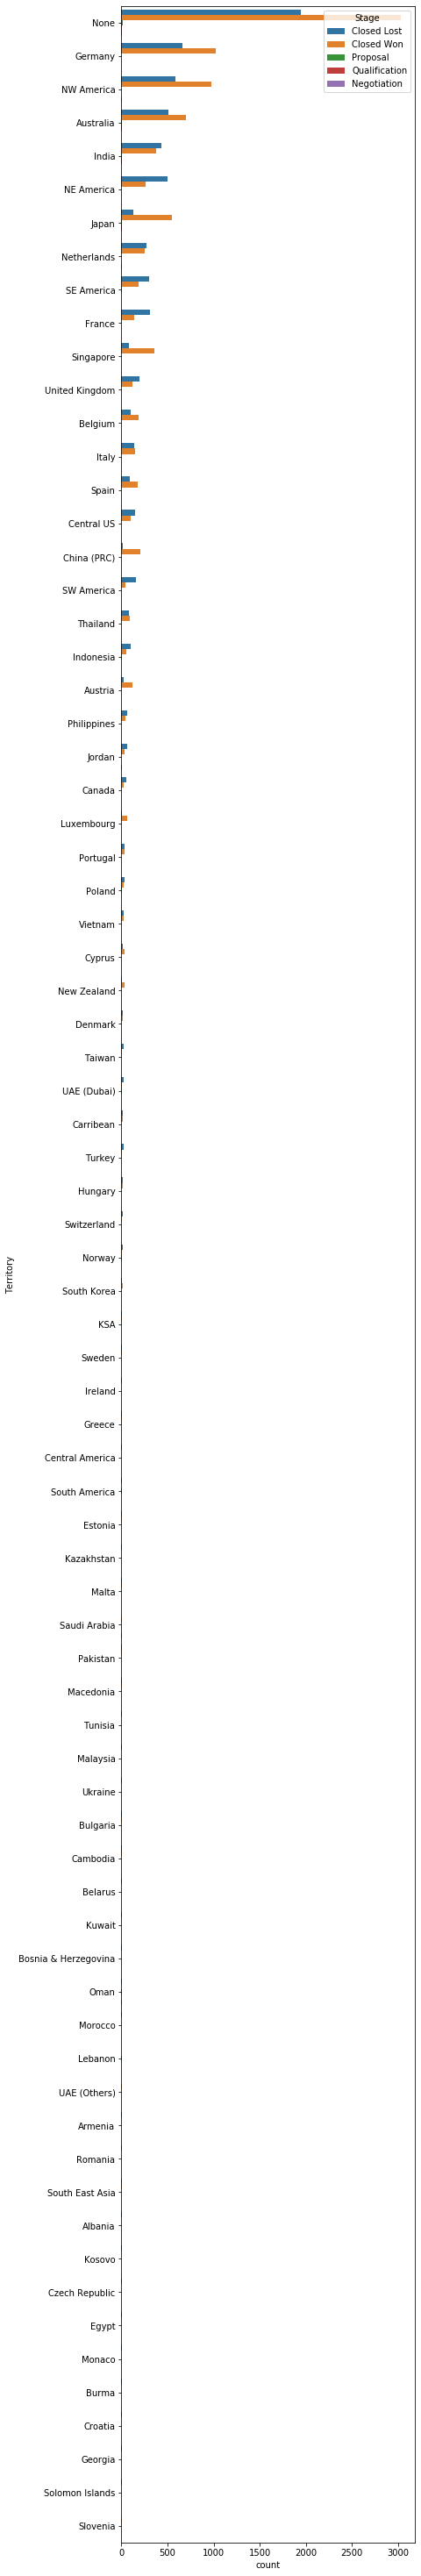

                Closed_Won_Percentage  Opportunities_Count
None                         0.606921                 4999
Germany                      0.608205                 1682
NW America                   0.620536                 1568
Australia                    0.576159                 1208
India                        0.462299                  809
NE America                   0.340789                  760
Japan                        0.801762                  681
Netherlands                  0.482176                  533
SE America                   0.379310                  493
France                       0.318486                  449
Singapore                    0.809524                  441
United Kingdom               0.389776                  313
Belgium                      0.656140                  285
Italy                        0.526502                  283
Spain                        0.675373                  268
Central US                   0.409449                  2

In [9]:
a('Territory')

In [10]:
df_temp = df[df['Territory'] == 'None']['Region'].value_counts()
df_temp

Japan          4211
Americas        571
EMEA            187
Middle East      30
Name: Region, dtype: int64

### Conclusion
De las 16947 oportunidades en el Dataset 4999 no tienen `Territory`. De estas 4999, 4211 tienen `Region` == Japan.
La pregunta es como repartir las 788 restantes.

## Pricing, Delivery_Terms_Quote_Appr

Feature:  Pricing, Delivery_Terms_Quote_Appr


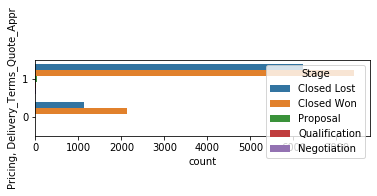

   Closed_Won_Percentage  Opportunities_Count
1               0.541518                13693
0               0.650891                 3254



In [9]:
a('Pricing, Delivery_Terms_Quote_Appr')

### Conclusión
Utilizar `Pricing, Delivery_Terms_Quote_Appr` para el modelo

## Pricing, Delivery_Terms_Approved

Feature:  Pricing, Delivery_Terms_Approved


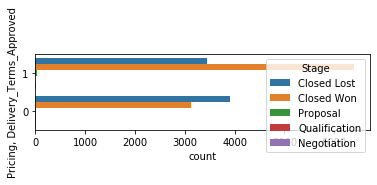

   Closed_Won_Percentage  Opportunities_Count
1               0.647523                 9890
0               0.443390                 7057



In [10]:
a('Pricing, Delivery_Terms_Approved')

### Conclusión
Utilizar la variable para el análisis

## Bureaucratic_Code_0_Approval

Feature:  Bureaucratic_Code_0_Approval


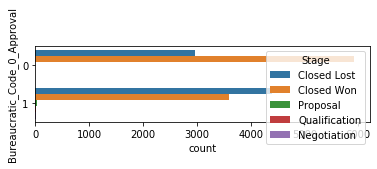

   Closed_Won_Percentage  Opportunities_Count
0               0.666892                 8889
1               0.447381                 8058



In [11]:
a('Bureaucratic_Code_0_Approval')

### Conclusión
Utilizar la variable para el análisis

## Bureaucratic_Code_0_Approved

Feature:  Bureaucratic_Code_0_Approved


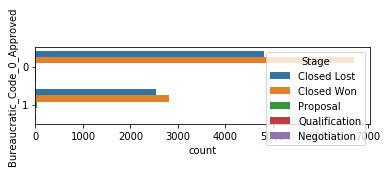

   Closed_Won_Percentage  Opportunities_Count
0               0.581738                11543
1               0.521466                 5404



In [12]:
a('Bureaucratic_Code_0_Approved')

### Conclusión
Utilizar la variable para el análisis

## Submitted_for_Approval

Feature:  Submitted_for_Approval


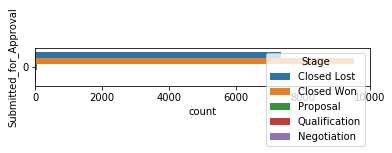

   Closed_Won_Percentage  Opportunities_Count
0               0.562518                16947



In [13]:
a('Submitted_for_Approval')

### Conclusión
NO Utilizar la variable para el análisis

## Bureaucratic_Code

Feature:  Bureaucratic_Code


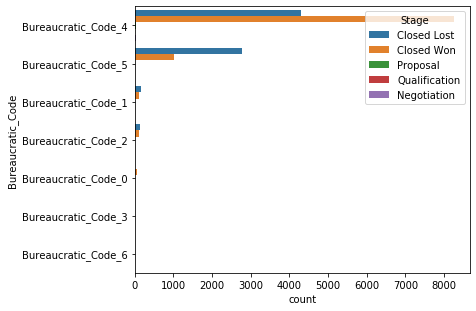

                     Closed_Won_Percentage  Opportunities_Count
Bureaucratic_Code_4               0.655676                12587
Bureaucratic_Code_5               0.265843                 3803
Bureaucratic_Code_1               0.390805                  261
Bureaucratic_Code_2               0.471074                  242
Bureaucratic_Code_0               1.000000                   51
Bureaucratic_Code_3               0.500000                    2
Bureaucratic_Code_6               1.000000                    1



In [14]:
a('Bureaucratic_Code')

### Conclusión
Utilizar la variable para el análisis

## Account_Created_Date

Feature:  Account_Created_Date


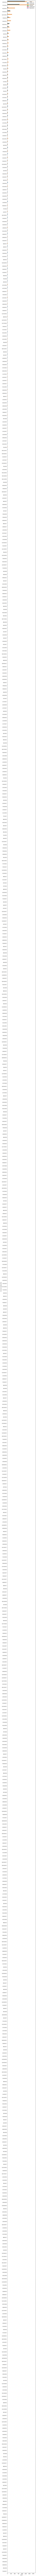

            Closed_Won_Percentage  Opportunities_Count
4/20/2015                0.602126                 3011
7/27/2013                0.688376                 2641
9/23/2013                0.885860                  587
9/19/2014                0.513854                  397
12/21/2015               0.909859                  355
...                           ...                  ...
2/21/2018                0.222222                    9
4/28/2016                0.666667                    9
1/23/2014                0.000000                    9
6/24/2017                0.777778                    9
3/25/2014                0.000000                    9

[242 rows x 2 columns]



In [44]:
a('Account_Created_Date')

### Conclusión
Fecha de creación de la cuenta. Los números parecen raros. En algunos días tienen cientos/miles de cuentas creadas. 
- Realizaron alguna migración de algún sistema?
- Es confiable este dato?
- No tienen mucho sentido que sea utilizado

Eliminar la feature.

## Source

Feature:  Source 


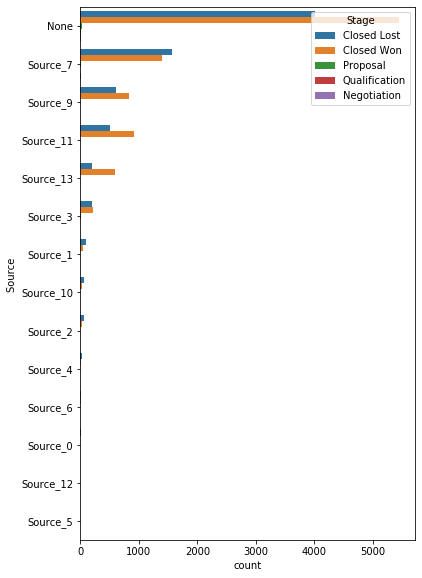

           Closed_Won_Percentage  Opportunities_Count
None                    0.573865                 9497
Source_7                0.469815                 2965
Source_9                0.575051                 1459
Source_11               0.644616                 1421
Source_13               0.746819                  786
Source_3                0.502392                  418
Source_1                0.350365                  137
Source_10               0.339623                  106
Source_2                0.348837                   86
Source_4                0.441860                   43
Source_6                0.263158                   19
Source_0                0.000000                    7
Source_12               0.000000                    2
Source_5                0.000000                    1



In [15]:
a('Source ')

### Conclusión
Utilizar la feature

## Billing_Country

Feature:  Billing_Country


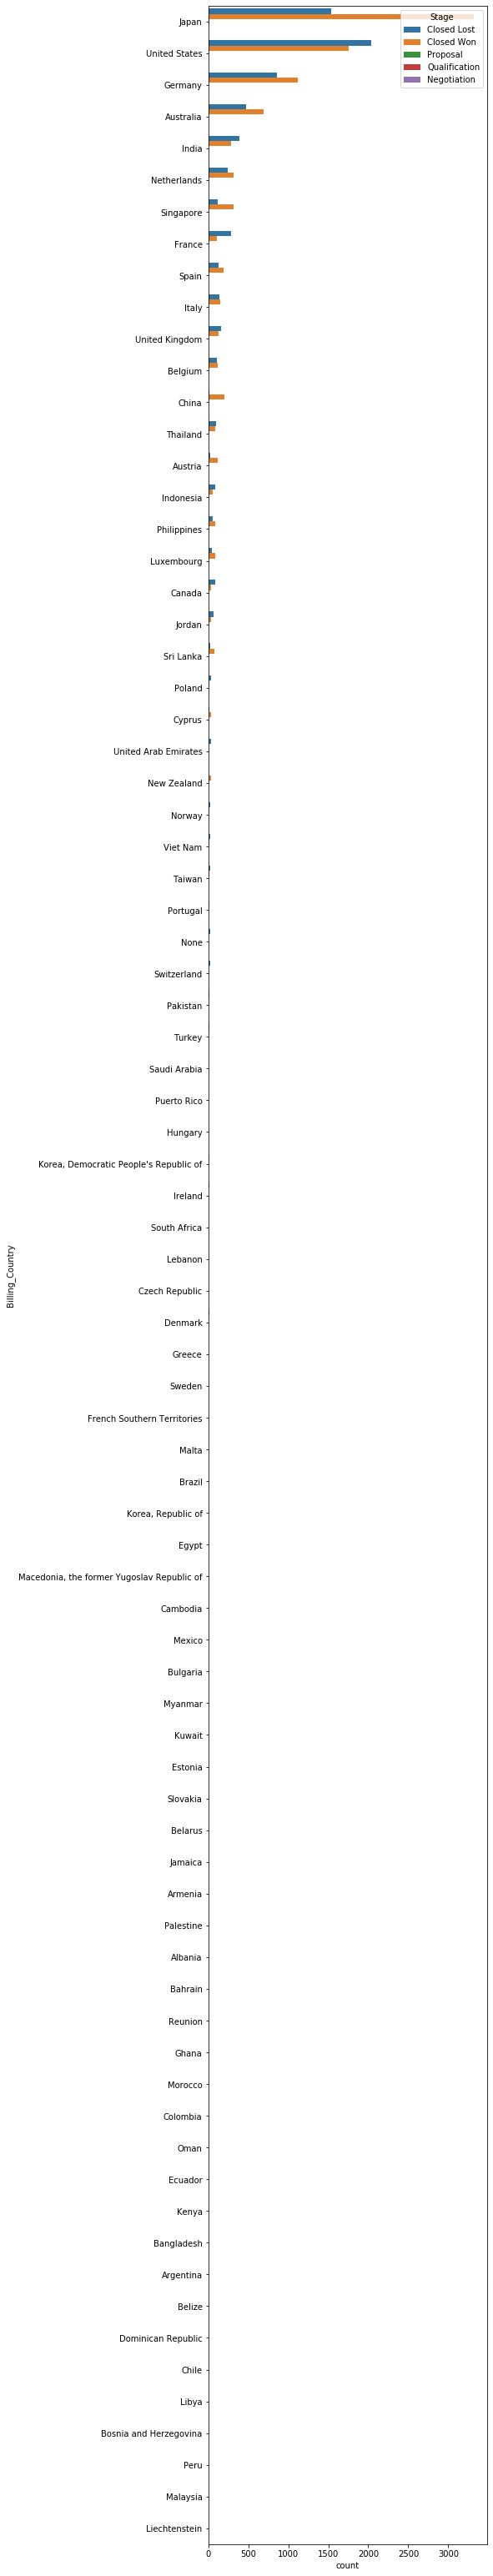

                      Closed_Won_Percentage  Opportunities_Count
Japan                              0.681082                 4879
United States                      0.461599                 3802
Germany                            0.566953                 1979
Australia                          0.594525                 1169
India                              0.422619                  672
Netherlands                        0.559503                  563
Singapore                          0.736111                  432
France                             0.280303                  396
Spain                              0.605678                  317
Italy                              0.515254                  295
United Kingdom                     0.447183                  284
Belgium                            0.526549                  226
China                              0.914414                  222
Thailand                           0.461538                  195
Austria                  

In [16]:
a('Billing_Country')

### Conclusión
Parece ser una feature a utilizar. Mis dudas son:
- Es importante para los clientes/potenciales clientes desde donde se realiza la facturación del proyecto?

##  Account_Name

In [48]:
a('Account_Name')

Feature:  Account_Name

Los valores únicos de  Account_Name son  1635

                   Closed_Won_Percentage  Opportunities_Count
Account_Name_1888               0.479284                 2124
Account_Name_1836               0.897291                  886
Account_Name_25                 0.716755                  752
Account_Name_1991               0.887372                  586
Account_Name_1642               0.513854                  397
...                                  ...                  ...
Account_Name_1327               0.000000                    4
Account_Name_390                0.750000                    4
Account_Name_487                0.000000                    4
Account_Name_1305               0.500000                    4
Account_Name_968                1.000000                    4

[490 rows x 2 columns]




### Conclusión
Utilizar la variable. Difiere el porcentaje de `Closed_Won` según el nombre de la cuenta

##  Opportunity_Name

In [24]:
a('Opportunity_Name')

Feature:  Opportunity_Name

Los valores únicos para  Opportunity_Name son  9841

                        Closed_Won_Percentage  Opportunities_Count
Opportunity_Name_9795                     1.0                   36
Opportunity_Name_5036                     1.0                   36
Opportunity_Name_12179                    0.0                   26
Opportunity_Name_11461                    0.0                   26
Opportunity_Name_6835                     0.0                   24
...                                       ...                  ...
Opportunity_Name_8061                     1.0                    1
Opportunity_Name_636                      0.0                    1
Opportunity_Name_5721                     1.0                    1
Opportunity_Name_10919                    0.0                    1
Opportunity_Name_4509                     1.0                    1

[2952 rows x 2 columns]



### Conclusión
NO utilizar esta variable parar el análisis. El nombre que adquiera la oportunidad no parece relevante a efectos de su impacto en `Closed_Won_Percentage`

## Opportunity_Created_Date

In [49]:
a('Opportunity_Created_Date')

Feature:  Opportunity_Created_Date

Los valores únicos de  Opportunity_Created_Date son  1096

           Closed_Won_Percentage  Opportunities_Count
6/30/2017               0.870968                  124
1/22/2016               0.093458                  107
5/9/2017                0.778846                  104
5/18/2016               0.101010                   99
1/7/2016                0.415730                   89
...                          ...                  ...
1/6/2017                0.777778                   18
8/18/2017               0.833333                   18
1/5/2018                0.722222                   18
3/26/2018               0.833333                   18
3/29/2018               0.500000                   18

[328 rows x 2 columns]




## Month

In [96]:
df['Month'] = pd.to_datetime(df['Month'])

Feature:  Month


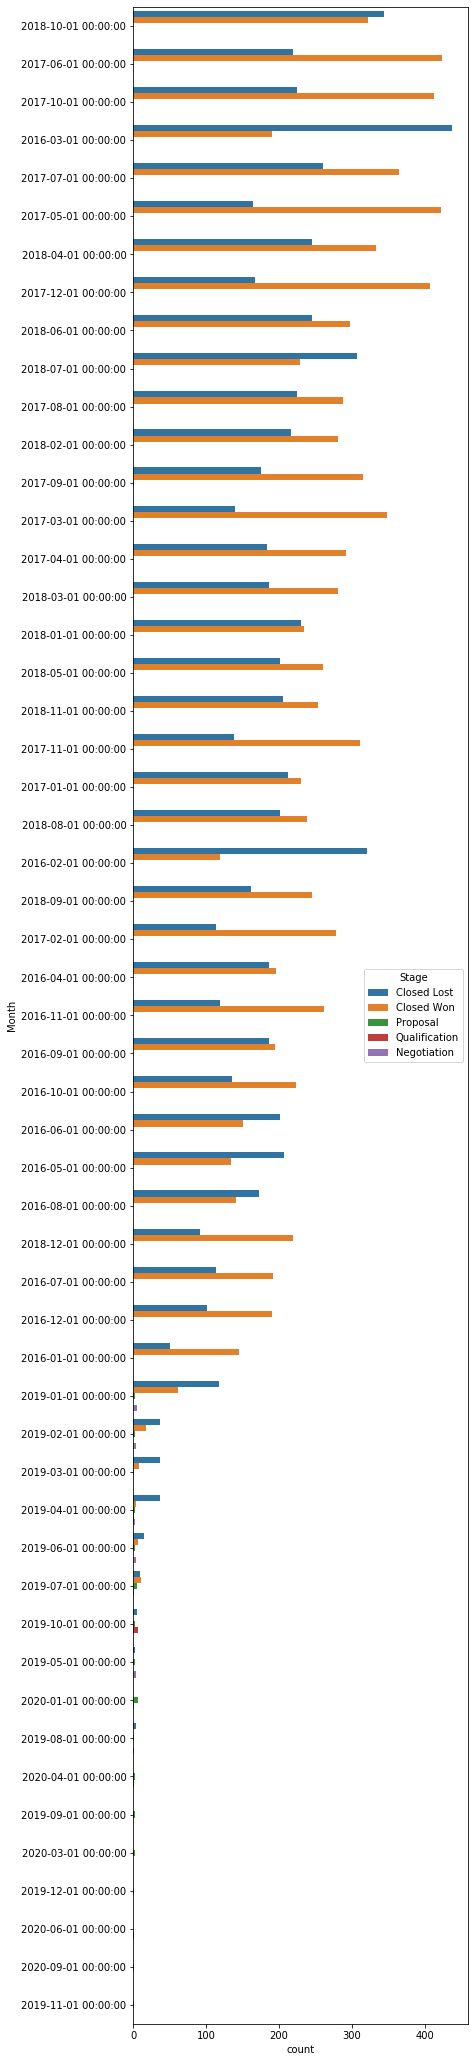

            Closed_Won_Percentage  Opportunities_Count
2018-10-01               0.483483                  666
2017-06-01               0.659409                  643
2017-10-01               0.647335                  638
2016-03-01               0.302548                  628
2017-07-01               0.584000                  625
2017-05-01               0.720137                  586
2018-04-01               0.576857                  579
2017-12-01               0.709059                  574
2018-06-01               0.547970                  542
2018-07-01               0.427239                  536
2017-08-01               0.561404                  513
2018-02-01               0.564257                  498
2017-09-01               0.641548                  491
2017-03-01               0.714579                  487
2017-04-01               0.614737                  475




In [97]:
a('Month')

In [98]:
feature = 'Month'
feature_Closed_Won_Percentage = []
feature_categories = df[feature].value_counts().index

for feature_category in feature_categories:
    feature_Closed_Won = len(df[(df[feature]==feature_category) & (df['Stage']=='Closed Won')]) / len(df[(df[feature]==feature_category)])
    feature_Closed_Won_Percentage.append(feature_Closed_Won)

# Creo una tabla con el porcentaje de oportunidades ganadas y la cantidad de instancias por cada valor único de la feature elegida
analisis_Month = pd.DataFrame({'Closed_Won_Percentage': feature_Closed_Won_Percentage,
                         'Opportunities_Count': df[feature].value_counts()})
analisis_Month

,Closed_Won_Percentage,Opportunities_Count
2018-10-01,0.483483,666
2017-06-01,0.659409,643
2017-10-01,0.647335,638
2016-03-01,0.302548,628
2017-07-01,0.584000,625
2017-05-01,0.720137,586
2018-04-01,0.576857,579
2017-12-01,0.709059,574
2018-06-01,0.547970,542
2018-07-01,0.427239,536


### Plotear Closed_Won_Percentage en el tiempo

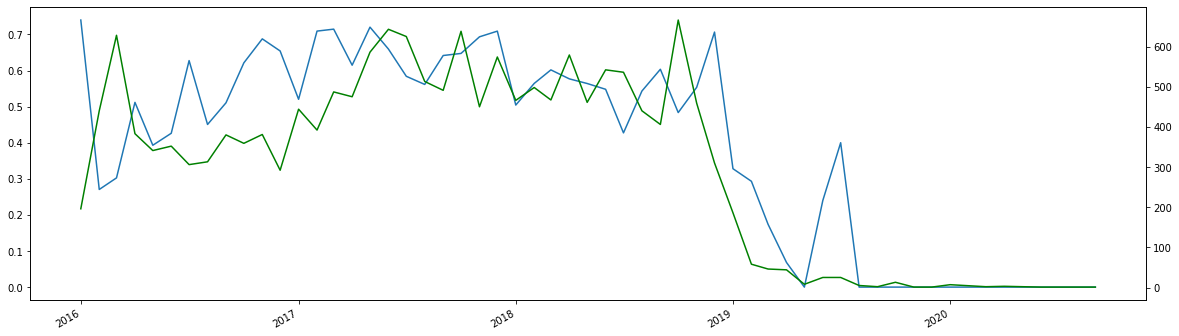

In [91]:
# analisis_Month.drop(columns=['Opportunities_Count']).plot(figsize=(20,6))
analisis_Month['Closed_Won_Percentage'].plot(figsize=(20,6))
analisis_Month['Opportunities_Count'].plot(figsize=(20,6),secondary_y=True, style='g')

## ASP_Converted

In [127]:
df_ASP = df[(df['Stage']=='Closed Won') | (df['Stage']=='Closed Lost')]
df_ASP = df_ASP[['Stage','ASP_(converted)']]
df_ASP = df_ASP[(df_ASP['ASP_(converted)']<1) & (df_ASP['ASP_(converted)']>0.1)]
df_ASP

,Stage,ASP_(converted)
0,Closed Lost,0.58817
1,Closed Won,0.59948
2,Closed Won,0.48000
3,Closed Lost,0.53000
4,Closed Lost,0.53000
...,...,...
16942,Closed Won,0.58817
16943,Closed Won,0.58817
16944,Closed Won,0.58817
16945,Closed Lost,0.63750


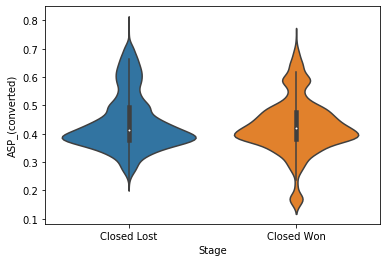

In [129]:
ax = sns.violinplot(x="Stage", y="ASP_(converted)", data=df_ASP)

## Total_Amount

In [130]:
df_Total_Amount = df[(df['Stage']=='Closed Won') | (df['Stage']=='Closed Lost')]
df_Total_Amount = df_Total_Amount[['Stage','Total_Amount']]
ax = sns.violinplot(x="Stage", y="Total_Amount", data=df_Total_Amount)

### Conclusión
No utilizar. La variable posee oportunidades con distintas monedas.

## Nueva variable plazo de delivery
Delivery_Time = Planned_Delivery_End_Date - Planned_Delivery_Start_Date

In [135]:
df['Delivery_Time'] = df['Planned_Delivery_End_Date']-df['Planned_Delivery_Start_Date']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16947 entries, 0 to 16946
Data columns (total 53 columns):
 #   Column                              Non-Null Count  Dtype          
---  ------                              --------------  -----          
 0   ID                                  16947 non-null  int64          
 1   Region                              16947 non-null  object         
 2   Territory                           16947 non-null  object         
 3   Pricing, Delivery_Terms_Quote_Appr  16947 non-null  int64          
 4   Pricing, Delivery_Terms_Approved    16947 non-null  int64          
 5   Bureaucratic_Code_0_Approval        16947 non-null  int64          
 6   Bureaucratic_Code_0_Approved        16947 non-null  int64          
 7   Submitted_for_Approval              16947 non-null  int64          
 8   Bureaucratic_Code                   16947 non-null  object         
 9   Account_Created_Date                16947 non-null  datetime64[ns] 
 10  Source    

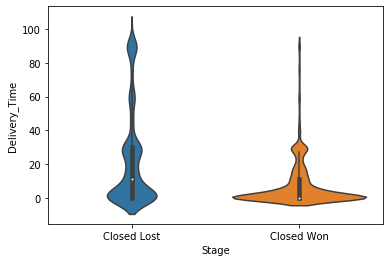

In [160]:
df_Delivery_Time = df[(df['Stage']=='Closed Won') | (df['Stage']=='Closed Lost')]
df_Delivery_Time = df_Delivery_Time[['Stage','Delivery_Time']]
df_Delivery_Time['Delivery_Time'] = df_Delivery_Time['Delivery_Time'].dt.components.days
df_Delivery_Time = df_Delivery_Time[df_Delivery_Time['Delivery_Time']<100]
ax = sns.violinplot(x="Stage", y="Delivery_Time", data=df_Delivery_Time)

In [161]:
df_Delivery_Time.info

<bound method DataFrame.info of              Stage  Delivery_Time
0      Closed Lost           60.0
1       Closed Won            2.0
2       Closed Won            0.0
3      Closed Lost           58.0
4      Closed Lost           27.0
...            ...            ...
16942   Closed Won            4.0
16943   Closed Won            4.0
16944   Closed Won            3.0
16945  Closed Lost            4.0
16946  Closed Lost           61.0

[16422 rows x 2 columns]>

#  Función de análisis en todas las features

Feature:  Region


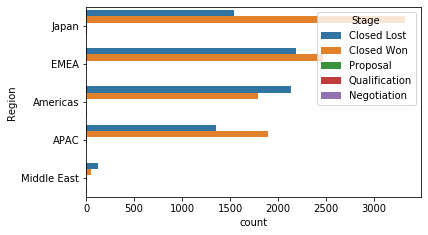

             Closed_Won_Percentage  Opportunities_Count
Japan                     0.679272                 4892
EMEA                      0.529803                 4664
Americas                  0.454499                 3945
APAC                      0.581239                 3262
Middle East               0.271739                  184


Feature:  Territory


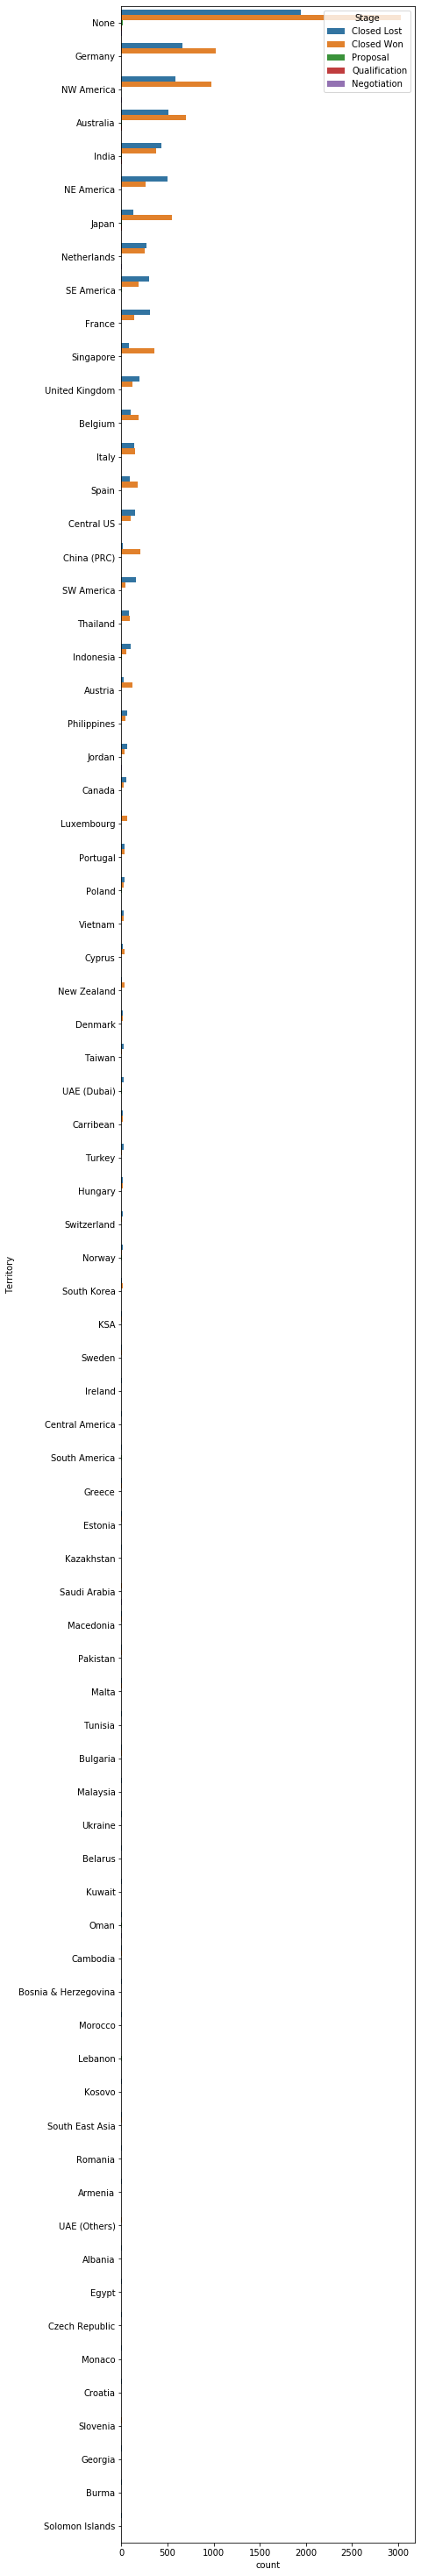

                Closed_Won_Percentage  Opportunities_Count
None                         0.606921                 4999
Germany                      0.608205                 1682
NW America                   0.620536                 1568
Australia                    0.576159                 1208
India                        0.462299                  809
NE America                   0.340789                  760
Japan                        0.801762                  681
Netherlands                  0.482176                  533
SE America                   0.379310                  493
France                       0.318486                  449
Singapore                    0.809524                  441
United Kingdom               0.389776                  313
Belgium                      0.656140                  285
Italy                        0.526502                  283
Spain                        0.675373                  268
Central US                   0.409449                  2

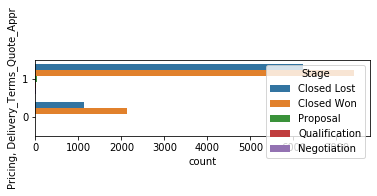

   Closed_Won_Percentage  Opportunities_Count
1               0.541518                13693
0               0.650891                 3254


Feature:  Pricing, Delivery_Terms_Approved


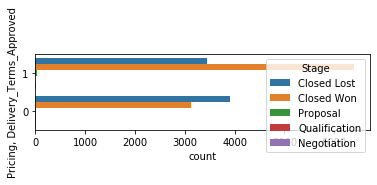

   Closed_Won_Percentage  Opportunities_Count
1               0.647523                 9890
0               0.443390                 7057


Feature:  Bureaucratic_Code_0_Approval


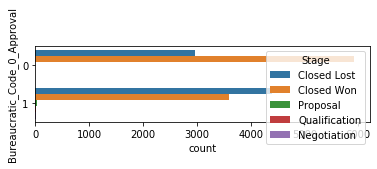

   Closed_Won_Percentage  Opportunities_Count
0               0.666892                 8889
1               0.447381                 8058


Feature:  Bureaucratic_Code_0_Approved


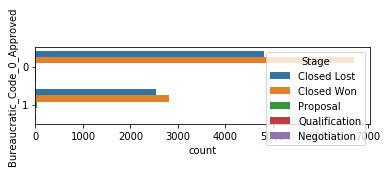

   Closed_Won_Percentage  Opportunities_Count
0               0.581738                11543
1               0.521466                 5404


Feature:  Submitted_for_Approval


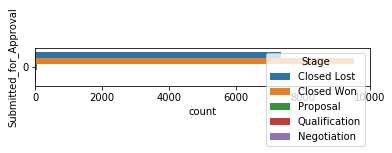

   Closed_Won_Percentage  Opportunities_Count
0               0.562518                16947


Feature:  Bureaucratic_Code


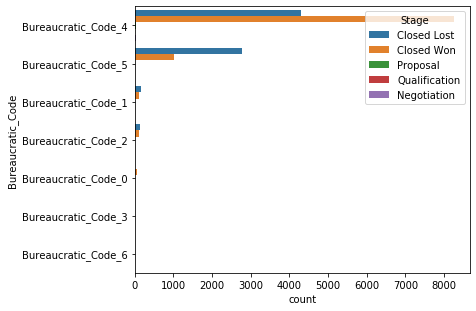

                     Closed_Won_Percentage  Opportunities_Count
Bureaucratic_Code_4               0.655676                12587
Bureaucratic_Code_5               0.265843                 3803
Bureaucratic_Code_1               0.390805                  261
Bureaucratic_Code_2               0.471074                  242
Bureaucratic_Code_0               1.000000                   51
Bureaucratic_Code_3               0.500000                    2
Bureaucratic_Code_6               1.000000                    1


Feature:  Account_Created_Date

Los valores únicos de  Account_Created_Date son  809

            Closed_Won_Percentage  Opportunities_Count
4/20/2015                0.602126                 3011
7/27/2013                0.688376                 2641
9/23/2013                0.885860                  587
9/19/2014                0.513854                  397
12/21/2015               0.909859                  355
...                           ...                  ...
9/24/2014      

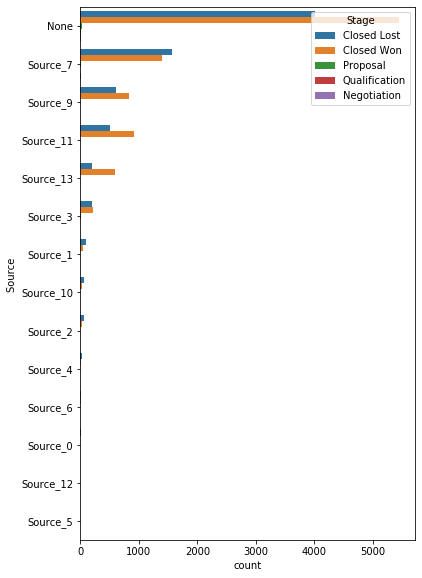

           Closed_Won_Percentage  Opportunities_Count
None                    0.573865                 9497
Source_7                0.469815                 2965
Source_9                0.575051                 1459
Source_11               0.644616                 1421
Source_13               0.746819                  786
Source_3                0.502392                  418
Source_1                0.350365                  137
Source_10               0.339623                  106
Source_2                0.348837                   86
Source_4                0.441860                   43
Source_6                0.263158                   19
Source_0                0.000000                    7
Source_12               0.000000                    2
Source_5                0.000000                    1


Feature:  Billing_Country


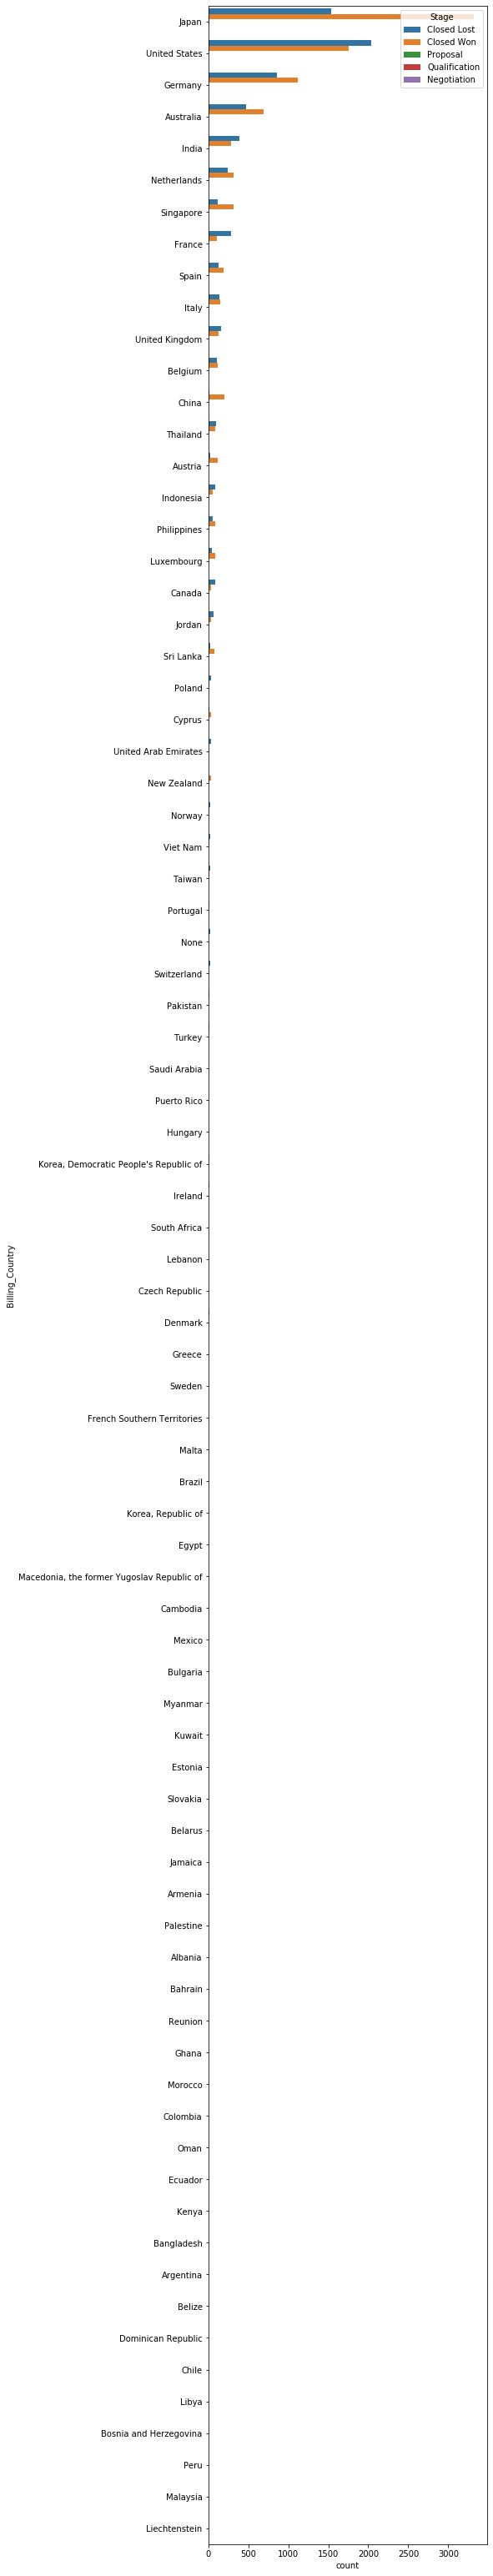

                      Closed_Won_Percentage  Opportunities_Count
Japan                              0.681082                 4879
United States                      0.461599                 3802
Germany                            0.566953                 1979
Australia                          0.594525                 1169
India                              0.422619                  672
Netherlands                        0.559503                  563
Singapore                          0.736111                  432
France                             0.280303                  396
Spain                              0.605678                  317
Italy                              0.515254                  295
United Kingdom                     0.447183                  284
Belgium                            0.526549                  226
China                              0.914414                  222
Thailand                           0.461538                  195
Austria                  

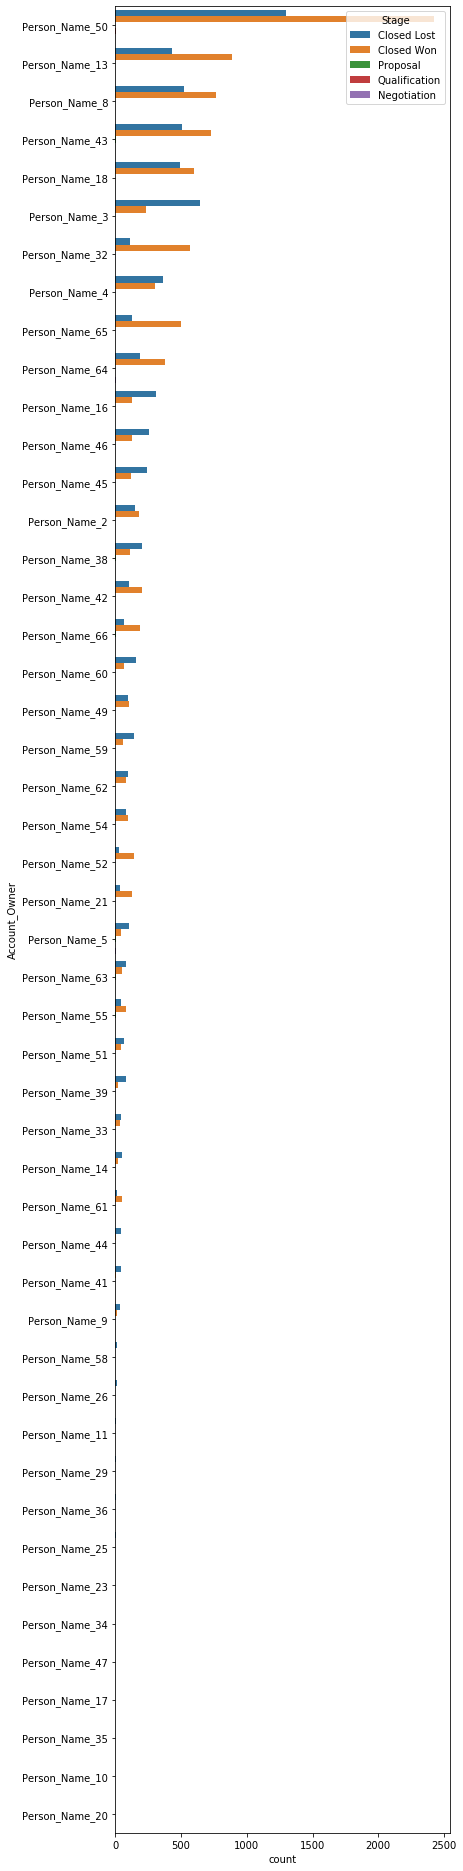

                Closed_Won_Percentage  Opportunities_Count
Person_Name_50               0.649598                 3730
Person_Name_13               0.670934                 1328
Person_Name_8                0.593313                 1286
Person_Name_43               0.585818                 1241
Person_Name_18               0.546203                 1093
Person_Name_3                0.266286                  875
Person_Name_32               0.837243                  682
Person_Name_4                0.453313                  664
Person_Name_65               0.798732                  631
Person_Name_64               0.658579                  577
Person_Name_16               0.287016                  439
Person_Name_46               0.333333                  381
Person_Name_45               0.327731                  357
Person_Name_2                0.549550                  333


Feature:  Opportunity_Owner


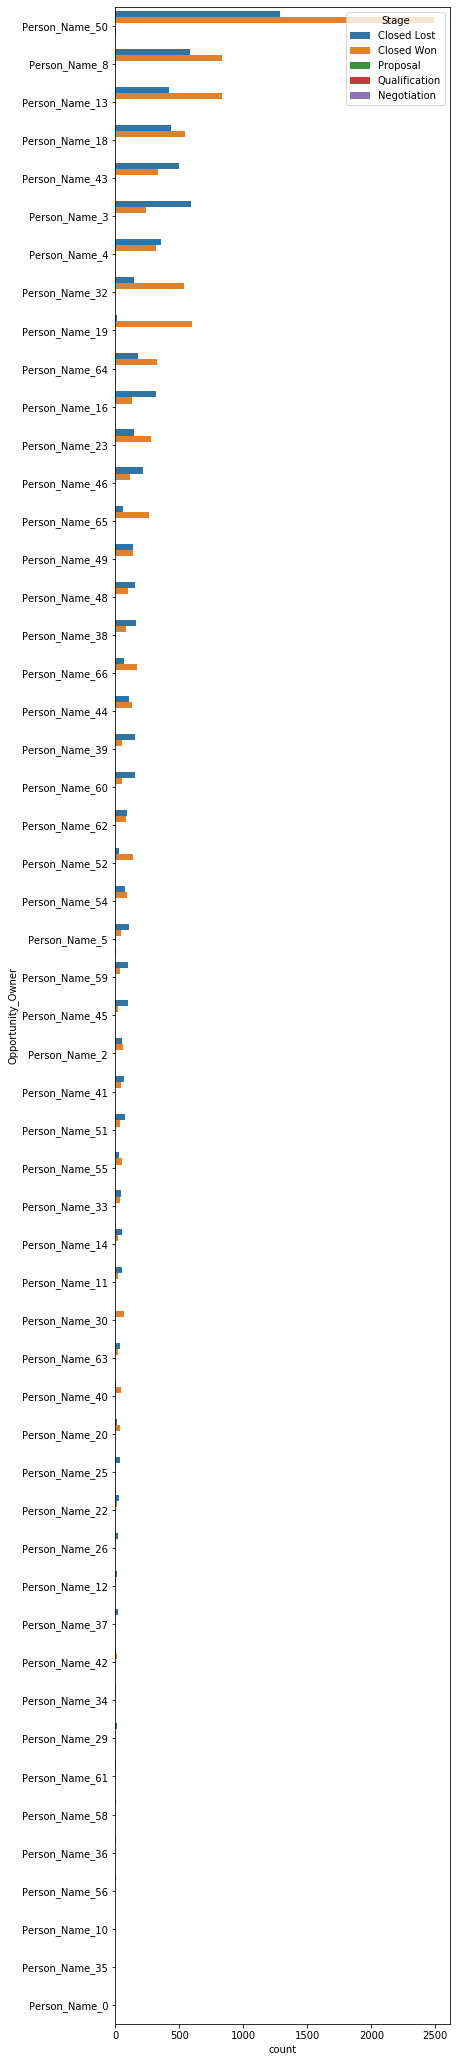

                Closed_Won_Percentage  Opportunities_Count
Person_Name_50               0.658291                 3781
Person_Name_8                0.587201                 1422
Person_Name_13               0.663477                 1254
Person_Name_18               0.559063                  982
Person_Name_43               0.400955                  838
Person_Name_3                0.286058                  832
Person_Name_4                0.470160                  687
Person_Name_32               0.782799                  686
Person_Name_19               0.973984                  615
Person_Name_64               0.639535                  516
Person_Name_16               0.286996                  446
Person_Name_23               0.658768                  422
Person_Name_46               0.343465                  329
Person_Name_65               0.816770                  322
Person_Name_49               0.496503                  286


Feature:  Account_Type


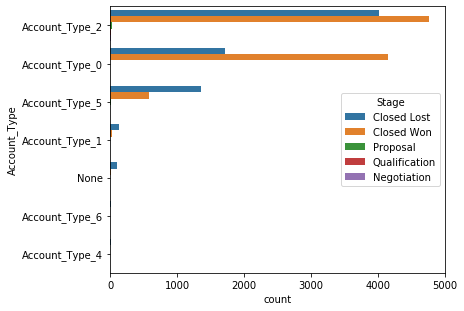

                Closed_Won_Percentage  Opportunities_Count
Account_Type_2               0.539515                 8832
Account_Type_0               0.706885                 5868
Account_Type_5               0.296963                 1943
Account_Type_1               0.187879                  165
None                         0.062500                  112
Account_Type_6               0.058824                   17
Account_Type_4               0.400000                   10


Feature:  Opportunity_Type


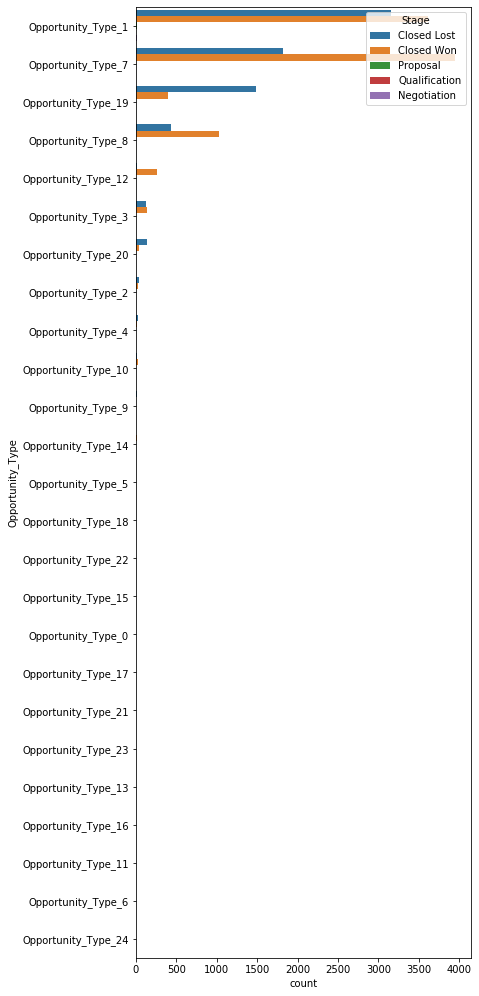

                     Closed_Won_Percentage  Opportunities_Count
Opportunity_Type_1                0.530430                 6819
Opportunity_Type_7                0.683845                 5763
Opportunity_Type_19               0.210000                 1900
Opportunity_Type_8                0.702332                 1458
Opportunity_Type_12               0.928315                  279
Opportunity_Type_3                0.512727                  275
Opportunity_Type_20               0.205714                  175


Feature:  Quote_Type


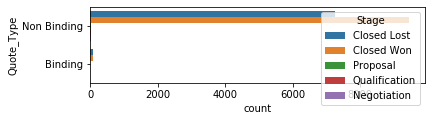

             Closed_Won_Percentage  Opportunities_Count
Non Binding               0.563092                16777
Binding                   0.505882                  170


Feature:  Delivery_Terms


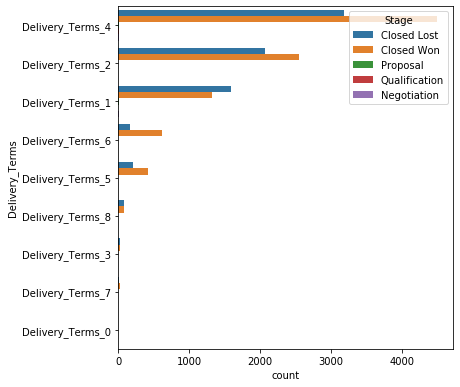

                  Closed_Won_Percentage  Opportunities_Count
Delivery_Terms_4               0.582988                 7712
Delivery_Terms_2               0.551479                 4633
Delivery_Terms_1               0.451294                 2936
Delivery_Terms_6               0.784891                  781
Delivery_Terms_5               0.658805                  636
Delivery_Terms_8               0.487805                  164
Delivery_Terms_3               0.487805                   41
Delivery_Terms_7               0.552632                   38
Delivery_Terms_0               0.666667                    6


Feature:  Opportunity_Created_Date

Los valores únicos de  Opportunity_Created_Date son  1096

           Closed_Won_Percentage  Opportunities_Count
6/30/2017               0.870968                  124
1/22/2016               0.093458                  107
5/9/2017                0.778846                  104
5/18/2016               0.101010                   99
1/7/2016               

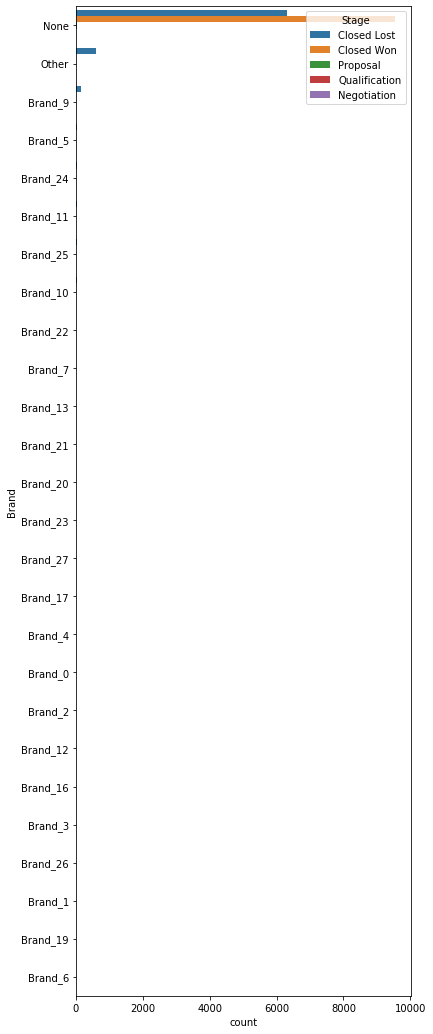

          Closed_Won_Percentage  Opportunities_Count
None                   0.599145                15911
Other                  0.000000                  607
Brand_9                0.000000                  140
Brand_5                0.000000                   48
Brand_24               0.000000                   38
Brand_11               0.000000                   34
Brand_25               0.000000                   24


Feature:  Product_Type


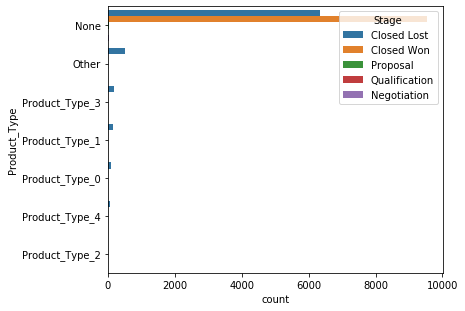

                Closed_Won_Percentage  Opportunities_Count
None                         0.598243                15935
Other                        0.000000                  515
Product_Type_3               0.000000                  179
Product_Type_1               0.000000                  142
Product_Type_0               0.000000                   94
Product_Type_4               0.000000                   73
Product_Type_2               0.000000                    9


Feature:  Size


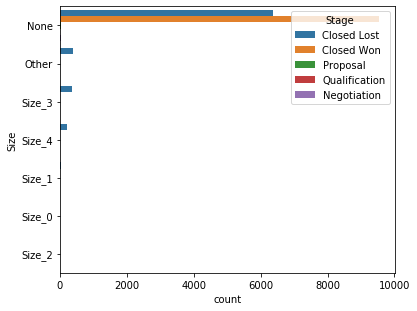

        Closed_Won_Percentage  Opportunities_Count
None                 0.597044                15967
Other                0.000000                  394
Size_3               0.000000                  356
Size_4               0.000000                  196
Size_1               0.000000                   25
Size_0               0.000000                    7
Size_2               0.000000                    2


Feature:  Product_Category_B


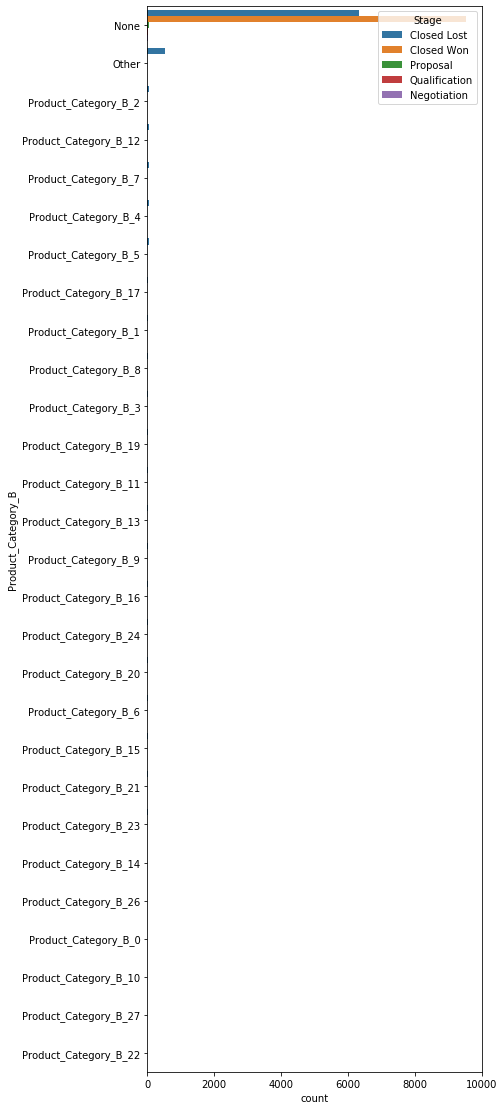

                       Closed_Won_Percentage  Opportunities_Count
None                                0.598506                15928
Other                               0.000000                  523
Product_Category_B_2                0.000000                   59
Product_Category_B_12               0.000000                   51
Product_Category_B_7                0.000000                   47
Product_Category_B_4                0.000000                   37
Product_Category_B_5                0.000000                   36
Product_Category_B_17               0.000000                   27


Feature:  Price


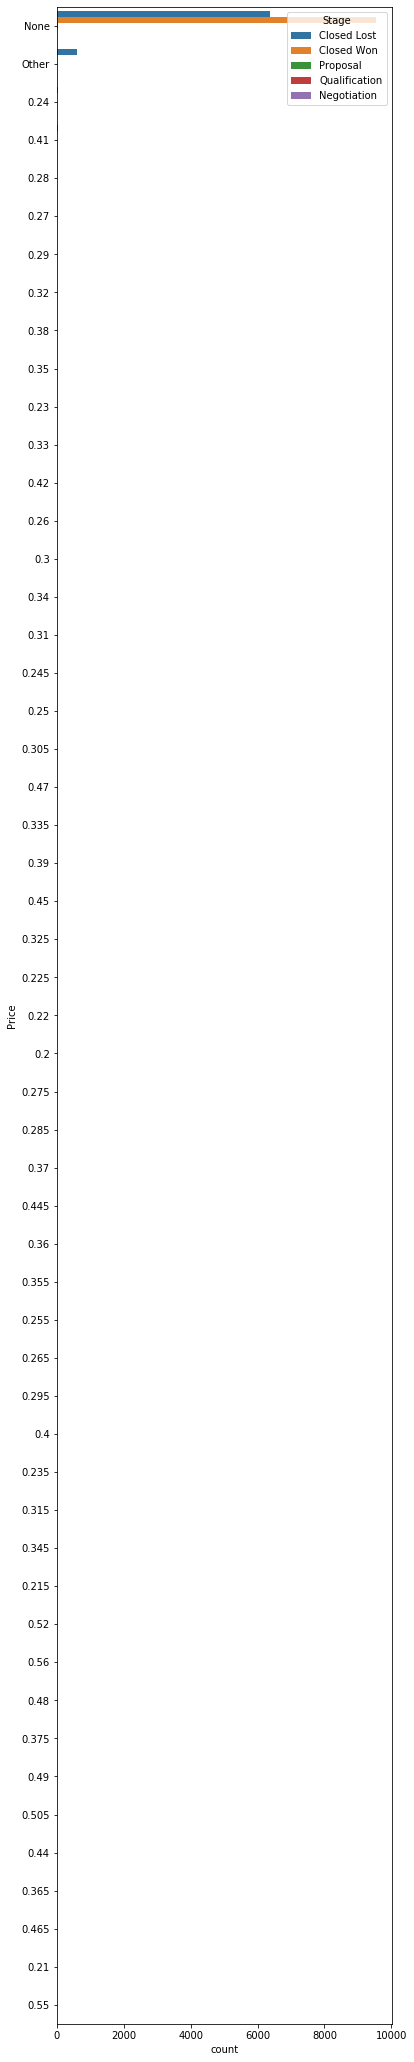

       Closed_Won_Percentage  Opportunities_Count
None                0.596484                15982
Other               0.000000                  609
0.24                0.000000                   27
0.41                0.000000                   22
0.28                0.000000                   20
0.27                0.000000                   18
0.29                0.000000                   17
0.32                0.000000                   15
0.38                0.000000                   14
0.35                0.000000                   14
0.23                0.000000                   13
0.33                0.000000                   12
0.42                0.000000                   12
0.26                0.000000                   11
0.3                 0.000000                   11


Feature:  Currency


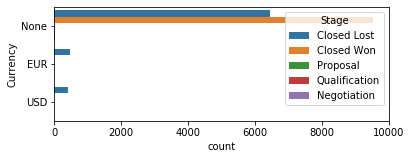

      Closed_Won_Percentage  Opportunities_Count
None               0.593882                16052
EUR                0.000000                  475
USD                0.000000                  420


Feature:  Last_Activity


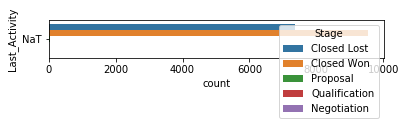

     Closed_Won_Percentage  Opportunities_Count
NaT               0.562518                16947


Feature:  Quote_Expiry_Date

Los valores únicos de  Quote_Expiry_Date son  1003

            Closed_Won_Percentage  Opportunities_Count
NaT                      0.319568                 4625
6/30/2017                0.701835                  436
3/31/2017                0.749311                  363
9/30/2017                0.773333                  225
12/31/2016               0.725000                  200
...                           ...                  ...
6/10/2016                0.900000                   10
1/6/2017                 0.600000                   10
3/14/2016                0.700000                   10
3/6/2017                 0.700000                   10
11/19/2018               0.800000                   10

[300 rows x 2 columns]


Feature:  Last_Modified_Date

Los valores únicos de  Last_Modified_Date son  650

            Closed_Won_Percentage  Opportunities_Coun

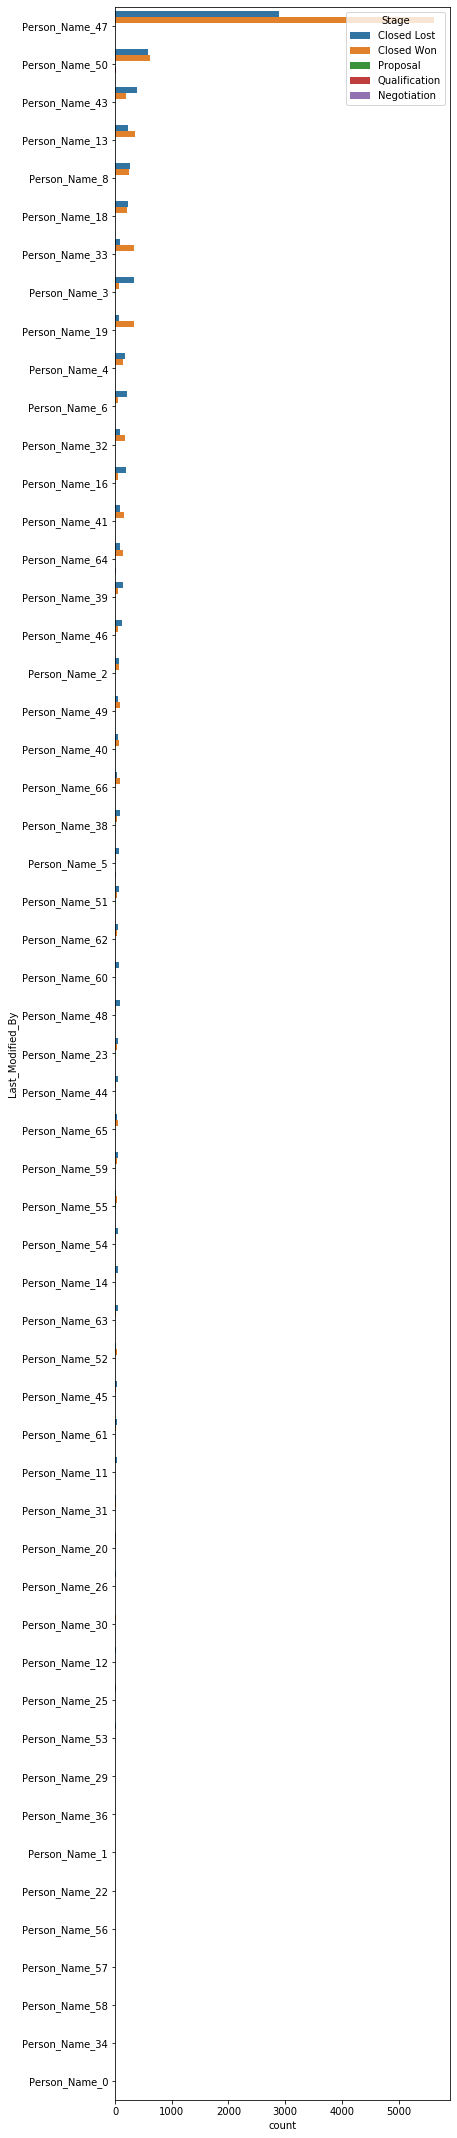

                Closed_Won_Percentage  Opportunities_Count
Person_Name_47               0.660482                 8515
Person_Name_50               0.507438                 1210
Person_Name_43               0.327087                  587
Person_Name_13               0.607266                  578
Person_Name_8                0.487280                  511
Person_Name_18               0.470320                  438
Person_Name_33               0.787879                  429
Person_Name_3                0.151899                  395
Person_Name_19               0.835443                  395
Person_Name_4                0.438095                  315
Person_Name_6                0.220077                  259
Person_Name_32               0.658730                  252
Person_Name_16               0.226721                  247
Person_Name_41               0.641350                  237
Person_Name_64               0.620690                  232
Person_Name_39               0.260870                  1

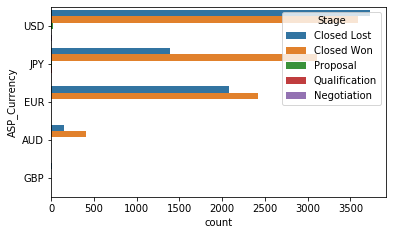

     Closed_Won_Percentage  Opportunities_Count
USD               0.487977                 7361
JPY               0.688191                 4522
EUR               0.537864                 4503
AUD               0.732014                  556
GBP               0.000000                    5


Feature:  ASP

Los valores únicos de  ASP son  301

        Closed_Won_Percentage  Opportunities_Count
0.380                0.520599                  801
0.400                0.595506                  712
0.360                0.455674                  564
0.420                0.645098                  510
0.390                0.425806                  465
...                       ...                  ...
0.570                0.483871                   31
66.000               0.962963                   27
0.235                0.461538                   26
0.358                0.440000                   25
0.245                0.600000                   25

[90 rows x 2 columns]


Feature:  ASP_(conver

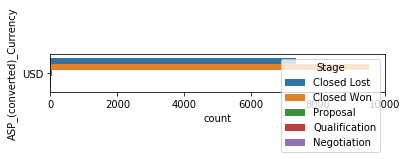

     Closed_Won_Percentage  Opportunities_Count
USD               0.562518                16947


Feature:  ASP_(converted)

Los valores únicos de  ASP_(converted) son  441

         Closed_Won_Percentage  Opportunities_Count
0.38000               0.503509                  570
0.40000               0.587525                  497
0.36000               0.407975                  326
0.39000               0.375385                  325
0.00000               0.806667                  300
...                        ...                  ...
0.26500               0.480000                   25
0.48071               0.560000                   25
0.57000               0.480000                   25
0.58000               0.500000                   24
0.56000               0.750000                   24

[132 rows x 2 columns]


Feature:  Planned_Delivery_Start_Date

Los valores únicos de  Planned_Delivery_Start_Date son  986

            Closed_Won_Percentage  Opportunities_Count
3/31/2016            

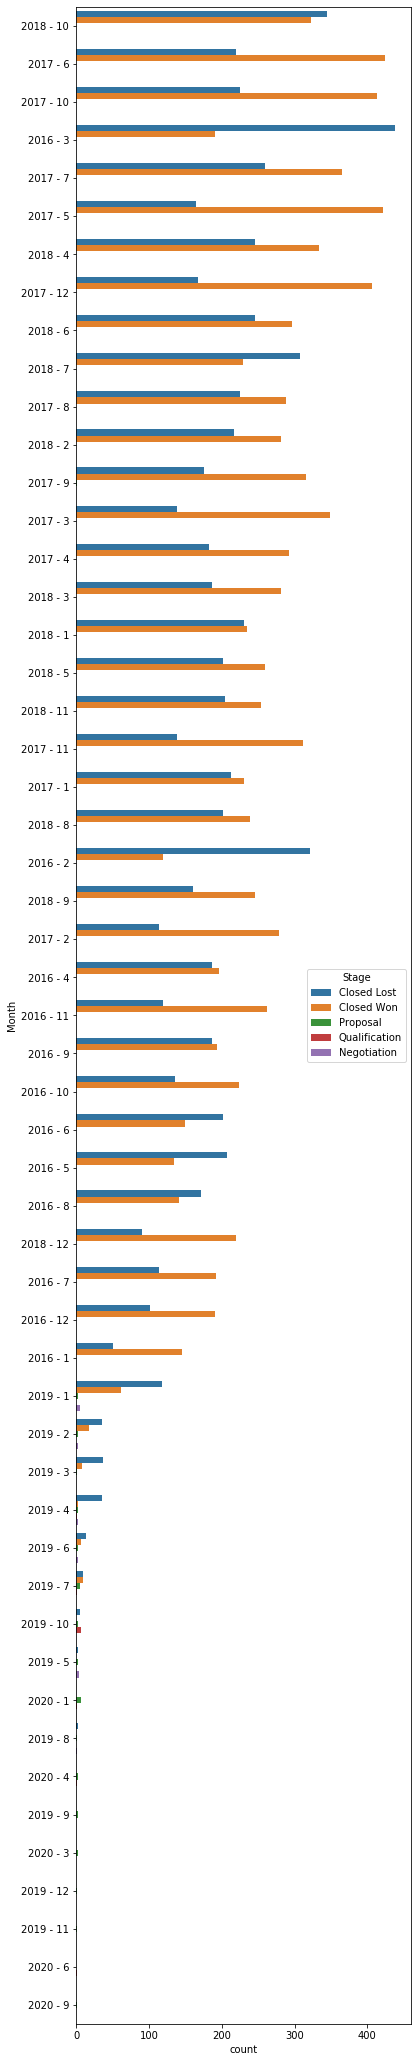

           Closed_Won_Percentage  Opportunities_Count
2018 - 10               0.483483                  666
2017 - 6                0.659409                  643
2017 - 10               0.647335                  638
2016 - 3                0.302548                  628
2017 - 7                0.584000                  625
2017 - 5                0.720137                  586
2018 - 4                0.576857                  579
2017 - 12               0.709059                  574
2018 - 6                0.547970                  542
2018 - 7                0.427239                  536
2017 - 8                0.561404                  513
2018 - 2                0.564257                  498
2017 - 9                0.641548                  491
2017 - 3                0.714579                  487
2017 - 4                0.614737                  475


Feature:  Delivery_Quarter


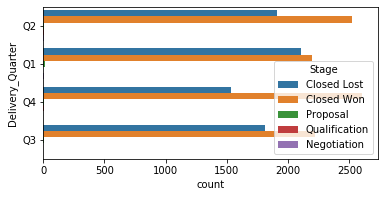

    Closed_Won_Percentage  Opportunities_Count
Q2               0.566734                 4443
Q1               0.508223                 4317
Q4               0.628137                 4144
Q3               0.548603                 4043


Feature:  Delivery_Year


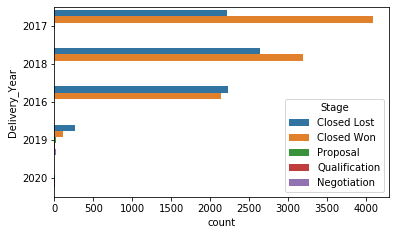

      Closed_Won_Percentage  Opportunities_Count
2017               0.648148                 6318
2018               0.548199                 5830
2016               0.488904                 4371
2019               0.253623                  414
2020               0.000000                   14


Feature:  Actual_Delivery_Date


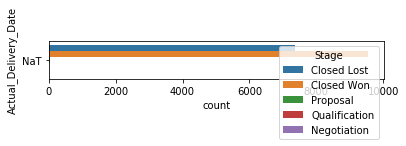

     Closed_Won_Percentage  Opportunities_Count
NaT               0.562518                16947


Feature:  TRF

Los valores únicos de  TRF son  101

    Closed_Won_Percentage  Opportunities_Count
0                0.687996                11971
1                0.395073                 2192
2                0.266348                  627
3                0.214689                  354
5                0.127946                  297
4                0.211538                  208
10               0.105263                  190
6                0.183206                  131
7                0.189189                  111
20               0.036145                   83
11               0.034483                   58
8                0.055556                   54
12               0.041667                   48
30               0.000000                   43
13               0.025000                   40
25               0.026316                   38
15               0.085714                   35
9   

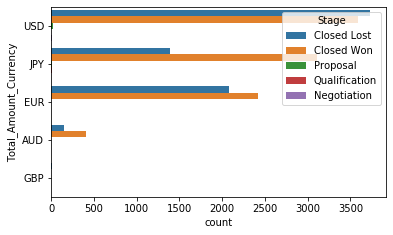

     Closed_Won_Percentage  Opportunities_Count
USD               0.487977                 7361
JPY               0.688191                 4522
EUR               0.537864                 4503
AUD               0.732014                  556
GBP               0.000000                    5


Feature:  Total_Amount

Los valores únicos de  Total_Amount son  8872

           Closed_Won_Percentage  Opportunities_Count
6200.0                  0.674464                  513
4400.0                  0.646421                  461
18000.0                 0.793201                  353
140000.0                0.643382                  272
1600.0                  0.813725                  204
...                          ...                  ...
41820.0                 0.000000                    1
5305300.0               0.000000                    1
2218705.0               0.000000                    1
109350.0                1.000000                    1
49025.0                 1.000000             

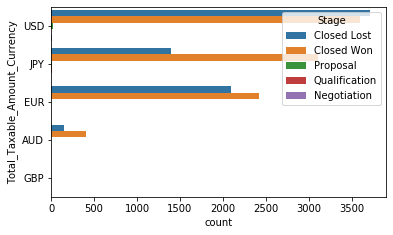

     Closed_Won_Percentage  Opportunities_Count
USD               0.488907                 7347
JPY               0.687735                 4525
EUR               0.536299                 4518
AUD               0.734177                  553
GBP               0.000000                    4


Feature:  Total_Taxable_Amount

Los valores únicos de  Total_Taxable_Amount son  7096

             Closed_Won_Percentage  Opportunities_Count
0.00                      0.257773                  997
588325.00                 1.000000                   72
109620.00                 0.941176                   68
488700.00                 1.000000                   66
413700.00                 0.000000                   60
...                            ...                  ...
29280.00                  1.000000                    2
29185.60                  0.500000                    2
4356000.00                1.000000                    2
40219000.00               0.000000                    2
49516.2

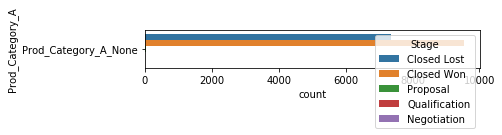

                      Closed_Won_Percentage  Opportunities_Count
Prod_Category_A_None               0.562518                16947




In [44]:
features= list(df.columns)
features.remove('Stage')
features.remove('ID')
for feature in features:
    a(feature)